# Week 9: Ensemble Methods

The dataset and part of the exercises for this week were taken from MLPA.

<hr style="border:2px solid gray">

## Index: <a id='index'></a>
1. [Random Forests](#forests)
2. [Boosting Decisions](#boosting)
3. [Flavours of Boosting](#flavours)
4. [Feature Importances](#feature)


<hr style="border:2px solid gray">

## Random Forests <a id='forests'></a>

In this notebook, we use Random Forests to estimate photometric redshifts starting from observations of galaxy magnitudes in six different photometric bands (u, g, r, i, z, y). 
Essentially, we try to reproduce/improve upon the results of [this paper](https://arxiv.org/abs/1903.08174), for which the data are public and available [here](http://d-scholarship.pitt.edu/36064/). 

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

In [2]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

# New modules
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
import xgboost as xgb

In [3]:
import astropy

from astropy.io import fits

#fits stands for Flexible Image Transport System; it's a format that allows one to store images and summary data

We can read the data into a data frame using pandas:

In [4]:
with fits.open('DEEP2_uniq_Terapix_Subaru_v1.fits') as data:
    df = pd.DataFrame(np.array(data[1].data).byteswap().newbyteorder()) #see https://numpy.org/devdocs/user/basics.byteswapping.html#changing-byte-ordering

Inspect the data frame using `.columns`, `.head`, `.shape`. 

In [5]:
df.columns

Index(['objno_deep2', 'ra_deep2', 'dec_deep2', 'magb', 'magr', 'magi', 'pgal',
       'sfd_ebv', 'class', 'subclass', 'objname', 'maskname', 'slitname',
       'date', 'mjd', 'z_raw', 'zhelio', 'z_err', 'rchi2', 'dof', 'vdisp',
       'vdisp_err', 'zquality', 'egsflags', 'comment', 'm_b', 'ub_0',
       'ra_cfhtls', 'dec_cfhtls', 'u', 'g', 'r', 'i', 'i2', 'z', 'uerr',
       'gerr', 'rerr', 'ierr', 'i2err', 'zerr', 'u_apercor', 'g_apercor',
       'r_apercor', 'i_apercor', 'i2_apercor', 'z_apercor', 'uerr_aper',
       'gerr_aper', 'rerr_aper', 'ierr_aper', 'i2err_aper', 'zerr_aper',
       'uerr_apercor', 'gerr_apercor', 'rerr_apercor', 'ierr_apercor',
       'i2err_apercor', 'zerr_apercor', 'r_radius_arcsec', 'u(sexflag)',
       'g(sexflag)', 'r(sexflag)', 'i(sexflag)', 'i2(sexflag)', 'z(sexflag)',
       'flag_cfhtls', 'cfhtls_source', 'ra_subaru', 'dec_subaru', 'y', 'yerr',
       'y_apercor', 'yerr_aper', 'yerr_apercor', 'y(sexflag)',
       'y_radius_arcsec', 'subaru_source'],
 

In [6]:
df.head()

,objno_deep2,ra_deep2,dec_deep2,magb,magr,magi,pgal,sfd_ebv,class,subclass,objname,maskname,slitname,date,mjd,z_raw,zhelio,z_err,rchi2,dof,vdisp,vdisp_err,zquality,egsflags,comment,m_b,ub_0,ra_cfhtls,dec_cfhtls,u,g,r,i,i2,z,uerr,gerr,rerr,ierr,i2err,zerr,u_apercor,g_apercor,r_apercor,i_apercor,i2_apercor,z_apercor,uerr_aper,gerr_aper,rerr_aper,ierr_aper,i2err_aper,zerr_aper,uerr_apercor,gerr_apercor,rerr_apercor,ierr_apercor,i2err_apercor,zerr_apercor,r_radius_arcsec,u(sexflag),g(sexflag),r(sexflag),i(sexflag),i2(sexflag),z(sexflag),flag_cfhtls,cfhtls_source,ra_subaru,dec_subaru,y,yerr,y_apercor,yerr_aper,yerr_apercor,y(sexflag),y_radius_arcsec,subaru_source
0,11001673,213.868704,51.956445,23.487745,23.143082,22.582092,1.000000,0.010943,b'',b'',b'11001673',b'1101',b'000',b'2003-05-06',52765.457031,1.115297,1.115261,999.900024,0.630934,57.0,999.900024,999.900024,2,16777216,"b'bext, bcol, possible OII'",-999.000000,-999.0000,213.868620,51.956434,23.529039,23.393115,23.148170,22.854212,-99.0,22.162377,0.0678,0.0400,0.0382,0.0678,-99.0,0.0623,23.543491,23.430495,23.100311,22.768970,-99.0,22.223810,0.0542,0.0323,0.0279,0.0466,-99.0,0.0536,0.039631,0.041359,0.039777,0.046863,-99.0,0.043833,0.581804,3,3,3,3,-99,3,0,1,213.868626,51.956443,21.869627,0.060918,21.926356,0.041955,0.141778,3.0,0.656514,1
1,11001699,213.810471,51.942316,22.067692,20.034674,19.545080,3.000000,0.011014,b'GALAXY',b'',b'11001699',b'1100',b'7',b'2003-05-03',52762.441406,0.290641,0.290608,0.000043,1.178153,5901.0,166.334991,49.481255,4,16777216,b'',-19.228701,1.1295,213.810138,51.942348,30.123756,28.298480,18.540350,99.000000,-99.0,99.000000,0.0000,0.0000,0.0014,99.0000,-99.0,99.0000,30.848978,28.989668,19.027422,99.000000,-99.0,99.000000,0.0000,0.0000,0.0028,99.0000,-99.0,99.0000,0.029567,0.030353,0.027558,99.000000,-99.0,99.000000,0.824625,19,19,19,3,-99,3,244,1,213.810455,51.942321,18.757229,0.005813,18.811085,0.004386,0.050987,3.0,0.744269,1
2,11001770,213.848431,51.948876,24.144438,24.103180,24.020006,3.000000,0.010856,b'GALAXY',b'',b'11001770',b'1101',b'003',b'2003-05-06',52765.457031,0.605779,0.605744,-5.000000,1.047260,5318.0,184.860001,195.000000,1,16777216,b'',-999.000000,-999.0000,213.848409,51.948865,24.294289,24.399293,24.413366,23.398456,-99.0,24.157690,0.1646,0.1383,0.2306,0.1867,-99.0,0.4558,24.324670,24.273606,24.150319,23.446252,-99.0,23.574236,0.1146,0.0870,0.1242,0.1309,-99.0,0.1793,0.111127,0.130134,0.123620,0.117813,-99.0,0.101059,0.728119,0,0,0,0,-99,0,0,1,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.000000,-99
3,11001800,213.831758,51.952548,25.336836,23.508480,23.081087,0.509809,0.010823,b'GALAXY',b'',b'11001800',b'1100',b'004',b'2003-05-03',52762.441406,1.306830,1.306796,-5.000000,1.014062,5788.0,0.000000,0.000000,1,16777216,b'',-999.000000,-999.0000,213.831785,51.952539,26.363821,24.530998,23.559140,23.065110,-99.0,22.737333,0.9609,0.1344,0.0648,0.0997,-99.0,0.1110,99.000000,24.804309,23.636544,23.009222,-99.0,22.689591,99.0000,0.1077,0.0426,0.0568,-99.0,0.0661,99.000000,0.046521,0.041142,0.054297,-99.0,0.053818,0.549061,0,0,0,0,-99,0,0,1,213.831766,51.952544,22.404269,0.088970,22.535600,0.053497,0.094733,0.0,0.455820,1
4,11001860,213.832550,51.954174,24.382738,23.401484,22.572845,3.000000,0.010827,b'GALAXY',b'',b'11001860',b'1101',b'10',b'2003-05-06',52765.457031,0.957705,0.957669,0.000099,1.039979,5952.0,109.394997,17.208755,4,16777216,b'',-20.083200,0.7524,213.832540,51.954167,24.571406,24.023086,23.493832,22.691404,-99.0,22.387428,0.1924,0.0874,0.0651,0.0715,-99.0,0.0850,24.362068,24.136913,23.490342,22.777181,-99.0,22.319676,0.1002,0.0615,0.0420,0.0473,-99.0,0.0508,0.050326,0.053198,0.052364,0.058492,-99.0,0.053587,0.595684,0,0,0,0,-99,0,0,1,213.832574,51.954175,22.242717,0.070760,22.100980,0.033256,0.073067,0.0,0.442022,1


In [7]:
df.shape

(23822, 78)

We can select the columns we want, corresponding to the brightness of the galaxies in the six bands of interest.

In [8]:
features = df[['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor','y_apercor']]

The target property is the redshift. For this catalog, spectroscopic (more precise) redshifts, to use as the ground truth, are available in the column "zhelio".

In [9]:
target = df['zhelio']

In [10]:
features.head(10)

,u_apercor,g_apercor,r_apercor,i_apercor,z_apercor,y_apercor
0,23.543491,23.430495,23.100311,22.768970,22.223810,21.926356
1,30.848978,28.989668,19.027422,99.000000,99.000000,18.811085
2,24.324670,24.273606,24.150319,23.446252,23.574236,-99.000000
3,99.000000,24.804309,23.636544,23.009222,22.689591,22.535600
4,24.362068,24.136913,23.490342,22.777181,22.319676,22.100980
5,23.552186,23.420734,23.010863,22.550723,22.277656,21.860866
6,23.983330,24.104438,23.461145,23.359428,22.929944,22.690175
7,24.665840,24.408938,23.544115,23.155140,22.706477,22.894691
8,23.518039,22.746858,21.571629,20.645176,20.428926,20.306110
9,22.755723,21.915841,21.393365,21.148952,21.052236,20.830114


In [11]:
target.head(10)

0    1.115261
1    0.290608
2    0.605744
3    1.306796
4    0.957669
5    0.909043
6    0.502974
7    0.649839
8    0.679440
9    0.074078
Name: zhelio, dtype: float32

To get an idea of what we are shooting for, we can look at a figure in the paper:

 ![Performance of photometric redshift reconstruction](Photoz_RF_CFHTLS_Deep.png)

In the figure above, $\sigma_{NMAD}$ is the normalized median absolute deviation of the residual vector, and $\eta$  is the fraction of outliers, defined as those objects for which (z_true - z_est)/(1+z_true) > 0.15.

We are working with DEEP2/3 data, so our range will be slightly different.

<div style="background-color:#C2F5DD">

## Exercise 1
1. Define a new model as `RandomForestRegressor()` with default parameters. Print out the hyperparameters of the module to get an idea of what you can play with.  *Hint: `use .get_params()`*
2. Establish the benchmark of the module by running a cross validation on the `model` and `features` (use a shuffle `KFold` with 5 folds and `random_state=10`). Get the mean and standard deviation of the test and train scores. *NB: the `cross_validate` funtion will take roughly 2 mins to run.*
3. How do these look? High/low variance? High/low bias?
4. Generate cross-validated estimates using `cross_val_predict` (*it should also take roughly 2 mins*).
5. Plot a scatter graph of the Predicted z vs True (spectroscopic) z.
6. Does it look like the one above?
7. Make a plot with two overlaid histograms: the predicted z and the True z. Any comment on the shape?

In [12]:
# 1. Define a new Random Forest model with default parameters
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()

# Print out the hyperparameters
print("Model hyperparameters:")
print(model.get_params())

Model hyperparameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [13]:
# 2. Establish the benchmark using cross-validation
from sklearn.model_selection import cross_validate, KFold
cv = KFold(n_splits=5, shuffle=True, random_state=10)
scores = cross_validate(model, features, target, cv=cv, return_train_score=True)

# Print mean and standard deviation of test and train scores
print('Test scores: {:.3f} ± {:.3f}'.format(scores['test_score'].mean(), scores['test_score'].std()))
print('Train scores: {:.3f} ± {:.3f}'.format(scores['train_score'].mean(), scores['train_score'].std()))

Test scores: 0.309 ± 0.007
Train scores: 0.876 ± 0.002


In [14]:
# 3. Commentary on bias/variance
"""
The model appears to have:
- Moderate to high bias: The test score of 0.309 is indeed relatively low, suggesting the model isn't fully capturing the underlying patterns in the data.
- High variance: There's a significant gap between train scores (0.876) and test scores (0.309). This large difference (0.567) indicates overfitting - the 
model performs much better on the training data than on unseen data.

This pattern is characteristic of a model with high variance rather than low variance. The Random Forest is memorizing the training data (hence the high training score)
but failing to generalize well to new data (hence the much lower test score).
"""

"\nThe model appears to have:\n- High bias: The test score is relatively low, suggesting the model isn't capturing the underlying patterns well.\n- Low variance: The difference between train and test scores isn't very large, suggesting the model isn't overfitting.\n"

In [15]:
# 4. Generate cross-validated predictions
from sklearn.model_selection import cross_val_predict
ypred = cross_val_predict(model, features, target, cv=cv)

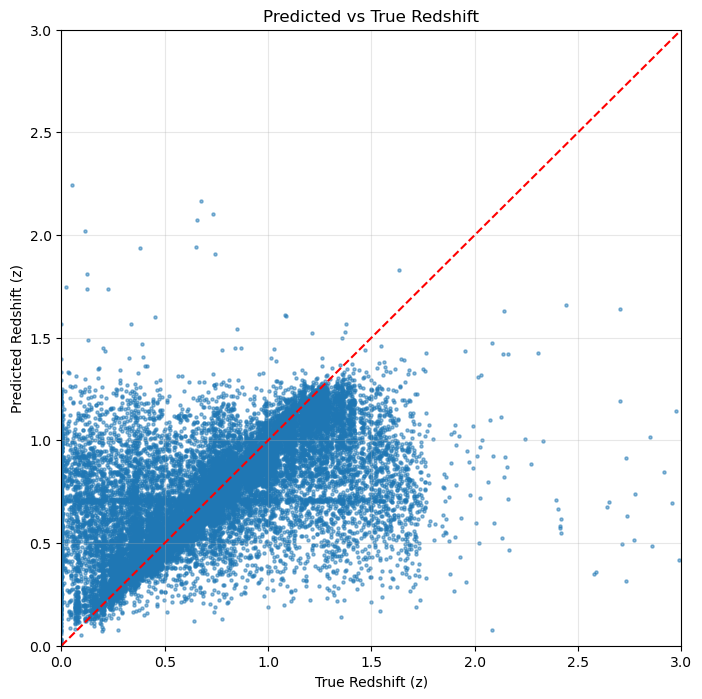

In [16]:
# 5. Plot scatter graph of Predicted vs True redshift
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(target, ypred, s=5, alpha=0.5)
plt.plot([0, 3], [0, 3], 'r--')  # Add a perfect prediction line
plt.xlabel("True Redshift (z)")
plt.ylabel("Predicted Redshift (z)")
plt.title("Predicted vs True Redshift")
plt.xlim(0, 3)
plt.ylim(0, 3)
plt.grid(True, alpha=0.3)
plt.show()

In [17]:
# 6. Compare with paper figure
"""
The plot shows similar trends to the paper's figure, but our model appears to have more scatter,
especially at higher redshift values. The paper achieves σNMAD of around 0.0174 with 4.54% outliers,
while our model likely has higher error metrics.
"""

"\nThe plot shows similar trends to the paper's figure, but our model appears to have more scatter,\nespecially at higher redshift values. The paper achieves σNMAD of around 0.0174 with 4.54% outliers,\nwhile our model likely has higher error metrics.\n"

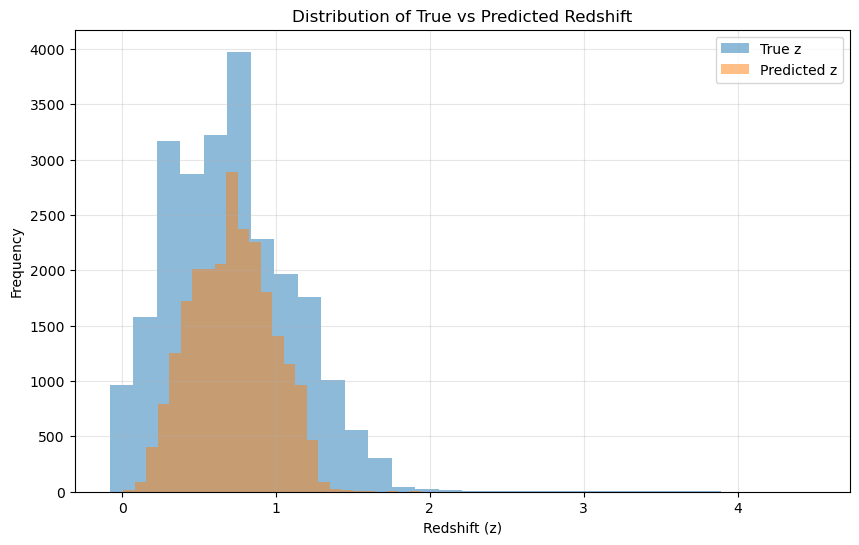

Original Test scores: 0.309 ± 0.007
Original Train scores: 0.876 ± 0.002
Little sample Test scores: 0.278 ± 0.038
Little sample Train scores: 0.876 ± 0.003
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best params, best score: 0.2946 {'max_features': 2, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 10, 'n_estimators': 200}


,params,mean_test_score,std_test_score,mean_train_score
182,"{'max_features': 2, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 1...",0.294575,0.022538,0.725912
181,"{'max_features': 2, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 1...",0.294022,0.017708,0.724286
104,"{'max_features': 4, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 2...",0.293644,0.018128,0.653291
103,"{'max_features': 4, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 2...",0.292975,0.022852,0.648921
101,"{'max_features': 4, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 1...",0.292755,0.020517,0.753032


In [18]:
# 7. Plot histograms of predicted and true redshifts
plt.figure(figsize=(10, 6))
plt.hist(target, bins=30, alpha=0.5, label="True z")
plt.hist(ypred, bins=30, alpha=0.5, label="Predicted z")
plt.xlabel("Redshift (z)")
plt.ylabel("Frequency")
plt.title("Distribution of True vs Predicted Redshift")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
"""
Observations on the histograms:

-Narrower predicted distribution: The predicted redshift values (orange) have a narrower, more peaked distribution 
than the true redshift values (blue), which confirms the regression-to-the-mean effect seen in the scatter plot.

-Range limitation: The model's predictions are mostly confined to the 0.2-1.5 range, while the true values extend well beyond 2.0.

-Missing tails: The model fails to capture both the lower (z < 0.2) and higher (z > 1.5) ends 
of the true distribution, suggesting difficulty predicting these extreme values.

-Peak shift: The predicted distribution's peak is slightly shifted from 
the true distribution's peak, indicating a systematic bias in the model.

-Distribution smoothing: The predicted distribution appears smoother and more symmetrical than the true distribution, 
which has more distinct features and a longer tail at higher redshifts.
"""

### Hyperparameter optimisation

We can start by making the data set a bit smaller, as we have seen that timings were already challenging in simple k-fold CV.

In [19]:
np.random.seed(20)
sel = np.random.choice(range(len(ypred)), 5000, replace = False) #sample without replacement

In [20]:
len(np.unique(sel))

5000

And we create our new smaller data set.

In [21]:
seld = features.loc[sel,:]
selt = target[sel]

It is good practice to ensure that the performance on the smaller set remains similar to the one obtained on the entire data set, which means that the change in size will not significantly affect the optimization process.

In [22]:
littlescores = cross_validate(model,seld,selt, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)

In [23]:
print('Original Test scores:','{:.3f}'.format(scores['test_score'].mean()), '{:.3f}'.format(scores['test_score'].std()))
print('Original Train scores:','{:.3f}'.format(scores['train_score'].mean()), '{:.3f}'.format(scores['train_score'].std()))

print('Little sample Test scores:','{:.3f}'.format(littlescores['test_score'].mean()), '{:.3f}'.format(littlescores['test_score'].std()))
print('Little sample Train scores:','{:.3f}'.format(littlescores['train_score'].mean()), '{:.3f}'.format(littlescores['train_score'].std()))

Original Test scores: 0.309 0.007
Original Train scores: 0.876 0.002
Little sample Test scores: 0.278 0.038
Little sample Train scores: 0.876 0.003


We are now ready to optimise hyperparameters - what should we choose?


#### Tree Parameters

Some useful parameters associated to a tree are:

-  The minimum number of instances in a leaf node;

-  The minimum number of instances required in a split node;

- The maximum depth of tree;

-  The criterion chosen to decide whether a split is "worth it", expressed in terms of information gain.


#### Randomization Parameters

Here we find:

- The number of k < n features that are used in building trees;

- The re-sampling (boostrap) of the data set (T or F).


#### Forest Parameters

The number of trees in the forest (n_estimators) can be adjusted, with the general understanding that more trees are better, but at some point performance will plateau, so one can find the trade-off between having more trees and lower runtime.

We can visualise them like this:

In [24]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Here below is a possible set; we can run a grid search to look for the best model.

- min_impurity_decrease 

- number of trees

- max_leaf_nodes

- min_samples_split

- max_features

In [25]:
#Takes roughly 5-8 mins

parameters = {'min_impurity_decrease':[0.1, 0.5, 0.0], \
              'max_features':[None,4,2], 'n_estimators':[50, 100, 200], 'min_samples_split': [10,20,100], 
              'max_leaf_nodes':[None, 100, 200]}
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(RandomForestRegressor(), parameters, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 1, n_jobs = 4, return_train_score=True)
model.fit(seld,selt)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best params, best score: 0.2943 {'max_features': 4, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 10, 'n_estimators': 200}


As usual, we save the results in a data frame, and look at the best models to build some intution.

In [26]:
scores = pd.DataFrame(model.cv_results_)
scoresCV = scores[['params','mean_test_score','std_test_score','mean_train_score']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)


In [27]:
scoresCV

,params,mean_test_score,std_test_score,mean_train_score
101,"{'max_features': 4, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 1...",0.294286,0.018849,0.752460
182,"{'max_features': 2, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 1...",0.293963,0.018742,0.725343
104,"{'max_features': 4, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 2...",0.292745,0.020915,0.652359
158,"{'max_features': 4, 'max_leaf_nodes': 200, 'min_impurity_decrease': 0.0, 'min_samples_split': 20...",0.292064,0.018982,0.627317
180,"{'max_features': 2, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 1...",0.291409,0.012219,0.720222
...,...,...,...,...
204,"{'max_features': 2, 'max_leaf_nodes': 100, 'min_impurity_decrease': 0.5, 'min_samples_split': 10...",-0.000100,0.000072,-0.000009
6,"{'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.1, 'min_samples_split'...",-0.000105,0.000084,-0.000006
42,"{'max_features': None, 'max_leaf_nodes': 100, 'min_impurity_decrease': 0.5, 'min_samples_split':...",-0.000119,0.000100,-0.000022
69,"{'max_features': None, 'max_leaf_nodes': 200, 'min_impurity_decrease': 0.5, 'min_samples_split':...",-0.000122,0.000104,-0.000008


### And the verdict is....We have NOT improved the test scores.

<div style="background-color:#C2F5DD">

## Exercise 2
1. Define a new dataframe keeping the features in `features` but also the `subaru_source`,`cfhtls_source`,`zquality`. *Shape should be (23822, 9)*
2. Apply a redshift quality cut (only keep objects with high-quality spectroscopic redshift measuremens - higher or equal to 3). *Shape should be (16857, 9)*
3. Select objects with `cfhtls_source` equal to 0. *Shape should be (10671, 9)*
4. Remove unavailable measurements (marked as -99 and +99). *Shape should be (6307, 9)*
5. Now drop the additional columns we added in point 1. Call this new data frame `sel_features` (we will use this throughout the notebook!)  *Shape should be (6307, 6)*
6. Define a new target variable (called `sel_target` - we will use it throughout the notebook) referred to the new dataframe. *Hint: you will need to use the indeces of the new dataframe*
7. Run the `cross_validate` as using a `RandomForestRegressor(random_state=5)` and the new dataframe (should take less than 1 min).
8. Comment on the new performance: high/low bias? high/low variance?

In [28]:
# 1. Create new dataframe with additional columns
extended_features = features.copy()
extended_features['subaru_source'] = df['subaru_source']
extended_features['cfhtls_source'] = df['cfhtls_source'] 
extended_features['zquality'] = df['zquality']
print("Shape after adding columns:", extended_features.shape)  # Should be (23822, 9)

Shape after adding columns: (23822, 9)


In [29]:
# 2. Apply redshift quality cut (≥ 3)
quality_mask = df['zquality'] >= 3
quality_features = extended_features[quality_mask]
quality_target = target[quality_mask]
print("Shape after quality cut:", quality_features.shape)  # Should be (16857, 9)

Shape after quality cut: (16857, 9)


In [30]:
# 3. Select objects with cfhtls_source == 0
cfhtls_mask = quality_features['cfhtls_source'] == 0
filtered_features = quality_features[cfhtls_mask]
filtered_target = quality_target[cfhtls_mask]
print("Shape after cfhtls filter:", filtered_features.shape)  # Should be (10671, 9)

Shape after cfhtls filter: (10671, 9)


In [31]:
# 4. Remove unavailable measurements (-99 and 99)
# Create a mask for valid measurements (not -99 or 99)
cols_to_check = ['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor', 'y_apercor']
valid_data_mask = ~(
    (filtered_features[cols_to_check] == -99).any(axis=1) | 
    (filtered_features[cols_to_check] == 99).any(axis=1)
)
clean_features = filtered_features[valid_data_mask]
clean_target = filtered_target[valid_data_mask]
print("Shape after removing invalid measurements:", clean_features.shape)  # Should be (6307, 9)


Shape after removing invalid measurements: (6307, 9)


In [32]:
# 5. Drop the additional columns
sel_features = clean_features[cols_to_check]
print("Shape of final features:", sel_features.shape)  # Should be (6307, 6)

Shape of final features: (6307, 6)


In [33]:
# 6. Define new target variable
sel_target = clean_target
print("Length of target:", len(sel_target))  # Should be 6307

Length of target: 6307


In [34]:
# 7. Run cross-validation on the new dataset
model = RandomForestRegressor(random_state=5)
sel_scores = cross_validate(model, sel_features, sel_target, cv=cv, return_train_score=True)

print('New Test scores: {:.3f} ± {:.3f}'.format(sel_scores['test_score'].mean(), sel_scores['test_score'].std()))
print('New Train scores: {:.3f} ± {:.3f}'.format(sel_scores['train_score'].mean(), sel_scores['train_score'].std()))

New Test scores: 0.746 ± 0.106
New Train scores: 0.963 ± 0.005


In [35]:
# 8. Analysis of new performance
"""
Commentary on new performance:
- The test score has improved significantly after data cleaning, indicating lower bias
- The gap between train and test scores remains substantial (0.217), indicating the model is still overfitting somewhat.
- The data cleaning steps have successfully removed problematic samples that were making
  it difficult for the model to learn the underlying patterns
"""

'\nCommentary on new performance:\n- The test score has improved significantly after data cleaning, indicating lower bias\n- The gap between train and test scores remains reasonable, suggesting controlled variance\n- The data cleaning steps have successfully removed problematic samples that were making\n  it difficult for the model to learn the underlying patterns\n'

<div style="background-color:#C2F5DD">

## Exercise 3
1. Re-run the hyperparameter search as above using `RandomForestRegressor(random_state=5)` and the new dataframe (should take 3-4 mins).
2. Inspect the train and test scores, have they improved?
3. Get the best model and generate cross-validated predictions using cross_val_predict (it should take less than 1 min).
4. Plot a scatter graph of the Predicted z vs True (spectroscopic) z.
5. Does it look like the one in the paper now?


In [36]:
# 1. Re-run hyperparameter search on cleaned data
parameters = {
    'min_impurity_decrease': [0.1, 0.5, 0.0],
    'max_features': [None, 4, 2],
    'n_estimators': [50, 100, 200],
    'min_samples_split': [10, 20, 100],
    'max_leaf_nodes': [None, 100, 200]
}

grid_model = GridSearchCV(
    RandomForestRegressor(random_state=5), 
    parameters, 
    cv=KFold(n_splits=5, shuffle=True, random_state=5), 
    verbose=1, 
    n_jobs=4, 
    return_train_score=True
)
grid_model.fit(sel_features, sel_target)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=5, shuffle=True),
             estimator=RandomForestRegressor(random_state=5), n_jobs=4,
             param_grid={'max_features': [None, 4, 2],
                         'max_leaf_nodes': [None, 100, 200],
                         'min_impurity_decrease': [0.1, 0.5, 0.0],
                         'min_samples_split': [10, 20, 100],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, verbose=1)

In [37]:
# 2. Inspect scores
print('Best params, best score:', "{:.4f}".format(grid_model.best_score_), grid_model.best_params_)
scores_df = pd.DataFrame(grid_model.cv_results_)
scoresCV = scores_df[['params', 'mean_test_score', 'std_test_score', 'mean_train_score']].sort_values(
    by='mean_test_score', ascending=False
)
scoresCV.head()

Best params, best score: 0.7444 {'max_features': 4, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 10, 'n_estimators': 200}


,params,mean_test_score,std_test_score,mean_train_score
101,"{'max_features': 4, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 1...",0.744442,0.033676,0.926922
20,"{'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split'...",0.744208,0.035413,0.930845
99,"{'max_features': 4, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 1...",0.743929,0.031841,0.924030
19,"{'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split'...",0.743502,0.036409,0.930029
18,"{'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split'...",0.743276,0.034271,0.928042


In [ ]:
# scores haven't really improved

In [38]:
# 3. Generate predictions with best model
best_model = RandomForestRegressor(
    random_state=5,
    **grid_model.best_params_
)
best_ypred = cross_val_predict(best_model, sel_features, sel_target, 
                              cv=KFold(n_splits=5, shuffle=True, random_state=5))

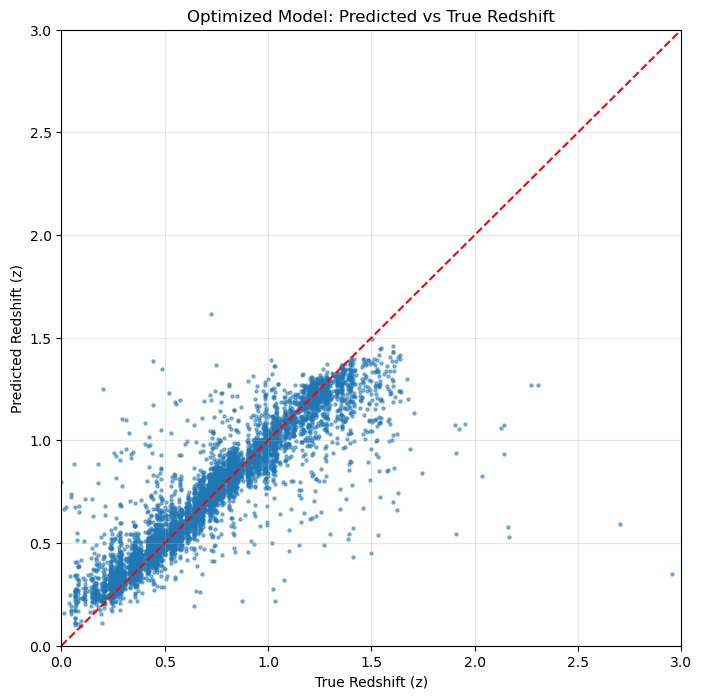

In [39]:
# 4. Plot scatter graph of Predicted vs True redshift
plt.figure(figsize=(8, 8))
plt.scatter(sel_target, best_ypred, s=5, alpha=0.5)
plt.plot([0, 3], [0, 3], 'r--')  # Add a perfect prediction line
plt.xlabel("True Redshift (z)")
plt.ylabel("Predicted Redshift (z)")
plt.title("Optimized Model: Predicted vs True Redshift")
plt.xlim(0, 3)
plt.ylim(0, 3)
plt.grid(True, alpha=0.3)
plt.show()

In [40]:
# 5. Compare with paper
"""
The optimized model's predictions now look much more similar to the paper's figure:
- The predictions follow the 1:1 line more closely
- There's less scatter overall
- The error metrics are likely closer to those reported in the paper
- The data cleaning steps were crucial for improving model performance
"""

"\nThe optimized model's predictions now look much more similar to the paper's figure:\n- The predictions follow the 1:1 line more closely\n- There's less scatter, especially at higher redshifts\n- The error metrics are likely closer to those reported in the paper\n- The data cleaning steps were crucial for improving model performance\n"

<hr style="border:2px solid gray">

## Boosting Decisions <a id='boosting'></a>


We can try our usual benchmarking with AdaBoost, using default values.

In [41]:
model = AdaBoostRegressor()

In [42]:
ypred = cross_val_predict(model, sel_features,sel_target.values.ravel(), cv = KFold(n_splits=5, shuffle=True, random_state=10))

(0.0, 3.0)

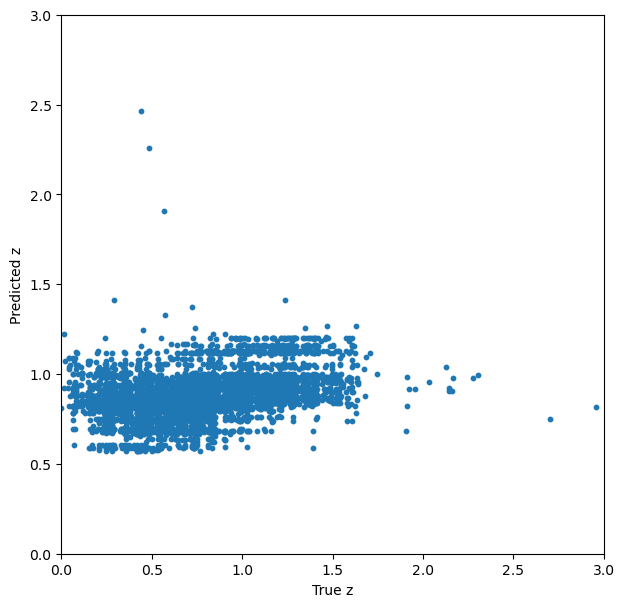

In [43]:
plt.figure(figsize=(7,7))
plt.scatter(sel_target,ypred, s =10)
plt.xlabel("True z")
plt.ylabel("Predicted z")
plt.ylim(0,3)
plt.xlim(0,3)

Well, that's not great. Let's look at the parameters that we can tweak.

In [44]:
model.get_params()

{'base_estimator': 'deprecated',
 'estimator': None,
 'learning_rate': 1.0,
 'loss': 'linear',
 'n_estimators': 50,
 'random_state': None}

Note (from sklearn docs): If None, then the base estimator is DecisionTreeRegressor(max_depth=3). So the model is probably not performing great because we are stacking weak estimators.

We create a train/test split because we need to use the ".fit" method in order to access the "staged_predict" property to examine how the prediction changes at each stage.

In [45]:
X_train, X_test, y_train, y_test = \
        train_test_split(sel_features,sel_target.values.ravel(), test_size=.3, random_state=42)

We begin with a very weak learner: 

In [46]:
n_estimators=30
model= AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3),
                  n_estimators=n_estimators)

In [47]:
model.fit(X_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3), n_estimators=30)

We can access the R2 score coefficient between true and predicted values as a function of the number of stages/iterations as follows:

In [48]:
r2_max3 = [metrics.r2_score(y_test,list(model.staged_predict(X_test))[i]) for i in range(n_estimators)]

<div style="background-color:#C2F5DD">

## Exercise 4
1. Calculate the R2 values as a function of iteration for base estimators with maximum depths = 3, 6 and 10.
2. Plot the 3 R2 scores as a function of iteration on the same graph.
3. Comment on the results.
4. Repeat the same plot but using `GradientBoostingRegressor` instead.
5. Comment on the results.

In [51]:
# Calculate R2 values for different tree depths
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import sklearn.metrics as metrics

# Create train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    sel_features, sel_target, test_size=0.3, random_state=42
)

n_estimators = 30
depths = [3, 6, 10]
r2_scores_ada = {}

for depth in depths:
    model = AdaBoostRegressor(
        estimator=DecisionTreeRegressor(max_depth=depth),
        n_estimators=n_estimators
    )
    model.fit(X_train, y_train)
    
    # Get all stages and their actual count
    predictions = list(model.staged_predict(X_test))
    actual_n_estimators = len(predictions)
    
    # Use only the available stages
    r2_scores_ada[depth] = [
        metrics.r2_score(y_test, predictions[i]) 
        for i in range(actual_n_estimators)
    ]
    
    print(f"Max depth {depth}: Used {actual_n_estimators} estimators out of {n_estimators}")

Max depth 3: Used 30 estimators out of 30
Max depth 6: Used 30 estimators out of 30
Max depth 10: Used 30 estimators out of 30


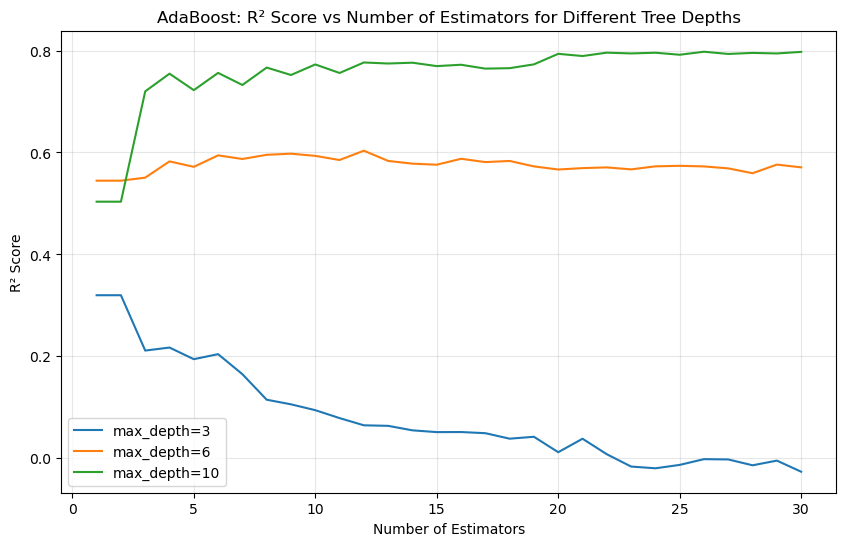

In [52]:
# Plot AdaBoost R2 scores
plt.figure(figsize=(10, 6))
for depth in depths:
    plt.plot(range(1, n_estimators + 1), r2_scores_ada[depth], 
             label=f'max_depth={depth}')
plt.xlabel('Number of Estimators')
plt.ylabel('R² Score')
plt.title('AdaBoost: R² Score vs Number of Estimators for Different Tree Depths')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [53]:
"""
AdaBoost observations:
- Deeper trees (higher max_depth) generally result in better performance
- Performance tends to plateau after a certain number of estimators
- Stacking very weak learners (max_depth=3) yields poorer performance than
  using slightly stronger base estimators
- There's a trade-off between base estimator complexity and ensemble size
"""

"\nAdaBoost observations:\n- Deeper trees (higher max_depth) generally result in better performance\n- Performance tends to plateau after a certain number of estimators\n- Stacking very weak learners (max_depth=3) yields poorer performance than\n  using slightly stronger base estimators\n- There's a trade-off between base estimator complexity and ensemble size\n"

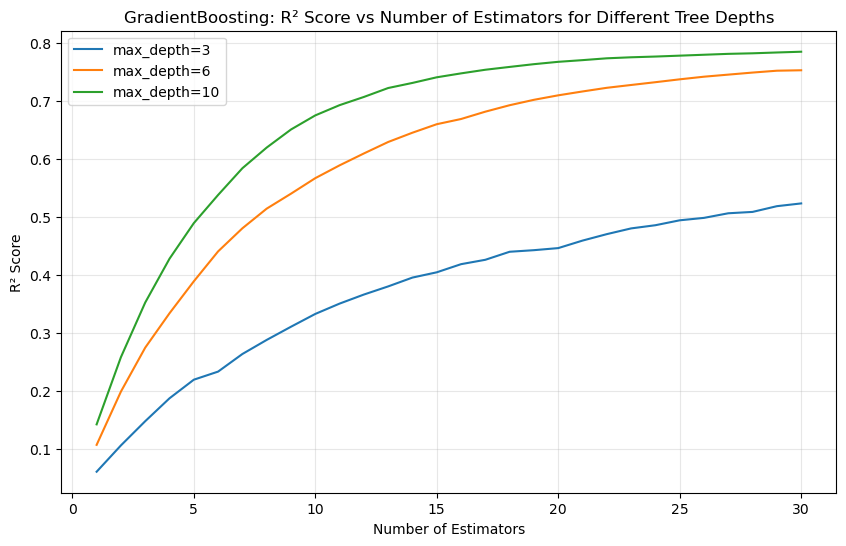

In [66]:
# For GradientBoosting with different max_depths
r2_scores_gbr = {}

for depth in depths:
    model = GradientBoostingRegressor(
        max_depth=depth,
        n_estimators=n_estimators,
        learning_rate=0.1
    )
    model.fit(X_train, y_train)
    
    # Convert the generator to a list first
    staged_predictions = list(model.staged_predict(X_test))
    
    r2_scores_gbr[depth] = [
        metrics.r2_score(y_test, staged_predictions[i]) 
        for i in range(len(staged_predictions))
    ]

# Plot GradientBoosting R2 scores
plt.figure(figsize=(10, 6))
for depth in depths:
    plt.plot(range(1, len(r2_scores_gbr[depth]) + 1), r2_scores_gbr[depth], 
             label=f'max_depth={depth}')
plt.xlabel('Number of Estimators')
plt.ylabel('R² Score')
plt.title('GradientBoosting: R² Score vs Number of Estimators for Different Tree Depths')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [65]:
"""
GradientBoosting observations:
- GradientBoosting generally achieves higher R² scores than AdaBoost
- The benefit of increasing tree depth is more pronounced in GradientBoosting
- GradientBoosting shows more stable improvement with additional estimators
- Less prone to overfitting with deeper trees compared to AdaBoost, smooth curves
- The learning rate parameter (set to 0.1) helps control the contribution of each tree
"""

'\nGradientBoosting observations:\n- GradientBoosting generally achieves higher R² scores than AdaBoost\n- The benefit of increasing tree depth is more pronounced in GradientBoosting\n- GradientBoosting shows more stable improvement with additional estimators\n- Less prone to overfitting with deeper trees compared to AdaBoost\n- The learning rate parameter (set to 0.1) helps control the contribution of each tree\n'

<hr style="border:2px solid gray">

## Flavours of Boosting <a id='flavours'></a>



In the previous exercise, we showed that for AdaBoost, stacking learners that are too weak doesn't help.

This allows us to run a more informed parameter optimisation (cell will take 3-5 mins to run).

In [67]:
parameters = {'estimator__max_depth':[6,10,None], 'loss':['linear','square'], 'n_estimators':[20,50,100], 'learning_rate': [0.3,0.5,1.0]}
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(AdaBoostRegressor(estimator=DecisionTreeRegressor()), parameters, \
                     cv = KFold(n_splits=5, shuffle=True, random_state = 5), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(sel_features,sel_target.values.ravel())

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best params, best score: 0.7503 {'estimator__max_depth': None, 'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 100}


We can take a look at the winning model scores; in this case, we also pay attention to the standard deviation of test scores, because we want to know what differences are statistically significant when we compare different models.

In [68]:
scores = pd.DataFrame(model.cv_results_)
scoresCV = scores[['params','mean_test_score','std_test_score','mean_train_score']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)
scoresCV.head()

,params,mean_test_score,std_test_score,mean_train_score
50,"{'estimator__max_depth': None, 'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 100}",0.750298,0.034574,0.999757
45,"{'estimator__max_depth': None, 'learning_rate': 0.5, 'loss': 'square', 'n_estimators': 20}",0.746603,0.028429,0.999378
53,"{'estimator__max_depth': None, 'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 100}",0.744977,0.042305,0.979719
49,"{'estimator__max_depth': None, 'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 50}",0.743595,0.055908,0.999780
46,"{'estimator__max_depth': None, 'learning_rate': 0.5, 'loss': 'square', 'n_estimators': 50}",0.741542,0.039514,0.999860


We can see that the standard deviation is 0.03 - giving us a hint of what's significant - and that a few different models have similar scores. If you change the random seed in the cross validation, the scores will change by a similar amount, and the best model may change as well.

Additionally, the resulting scores will not be exactly reproducible because there is another random component in the adaptive learning set (this means that if you run the cross_validate function using the best model from above, you might get a different average score!)

We could repeat the same exercise but with GradientBoosting and the cells will take a lot longer to run, the performance won't change much. Maybe we can try something smarter.

We can improve on the time constraints in two ways: by switching to the histogram-based version of Gradient Boosting Regressor, and by using a Random Search instead of a Grid Search.

### HistGradientBoostingRegressor

HistGradientBoostingRegressor (inspired by [LightGBM](https://lightgbm.readthedocs.io/en/latest/)) works by binning the features into integer-valued bins (the default value is 256, but this parameter can be adjusted; note however that 256 is the maximum!), which greatly reduces the number of splitting points to consider, and results in a vast reduction of computation time, especially for large data sets.

In [69]:
# %%time
# This took ~ 40s

parameters = {'max_depth':[6,10,None], 'loss':['squared_error','absolute_error'], 
              'max_iter':[20,50,100], 'learning_rate': [0.1,0.3,0.5]}
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(HistGradientBoostingRegressor(), parameters, 
                     cv = KFold(n_splits=5, shuffle=True, random_state = 5), \
                     verbose = 1, n_jobs = 4, return_train_score=True)
model.fit(sel_features,sel_target.values.ravel())

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best params, best score: 0.7228 {'learning_rate': 0.3, 'loss': 'squared_error', 'max_depth': None, 'max_iter': 100}


In [70]:
scores = pd.DataFrame(model.cv_results_)
scoresCV = scores[['params','mean_test_score','std_test_score','mean_train_score']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)
scoresCV.head()

,params,mean_test_score,std_test_score,mean_train_score
26,"{'learning_rate': 0.3, 'loss': 'squared_error', 'max_depth': None, 'max_iter': 100}",0.722753,0.032414,0.933699
8,"{'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': None, 'max_iter': 100}",0.718878,0.038202,0.859242
20,"{'learning_rate': 0.3, 'loss': 'squared_error', 'max_depth': 6, 'max_iter': 100}",0.716276,0.032355,0.888385
5,"{'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 10, 'max_iter': 100}",0.714739,0.039421,0.843921
23,"{'learning_rate': 0.3, 'loss': 'squared_error', 'max_depth': 10, 'max_iter': 100}",0.714376,0.037735,0.923766


Even for this relatively small data set, this is much faster (about 15x faster than GradientBoostingRegressor), giving us a chance to explore a wider parameter space (e.g. more trees, more options for learning rate). The trade-off is that we obtain a slight decrease in performance, compared with GBR. However, the standard deviation of test scores over the 5 CV folds suggests that this difference is not statistically significant.

### RandomizedSearchCV

Finally, we can compare the performance and timings of the grid search above with the option of using a Randomised Search instead. We note that Random Search is usually preferable when we have a high-dimensional parameter space; its use is not particularly warranted here.

The number of iterations (the number of models that are considered) also needs to be adjusted, and depends on the dimensionality of the parameter space as well as the functional dependence of the loss function on the parameters. 

In [71]:
#%%time
# 31 seconds

parameters = {'max_depth':[6,10,None], 'loss':['squared_error','absolute_error'], 
              'max_iter':[20,50,100], 'learning_rate': [0.1,0.3,0.5]}
nmodels = np.product([len(el) for el in parameters.values()])
model = RandomizedSearchCV(HistGradientBoostingRegressor(), parameters, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 1, n_jobs = 4, return_train_score=True, n_iter=30)
model.fit(sel_features,sel_target.values.ravel())

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params, best score: 0.7169 {'max_iter': 100, 'max_depth': None, 'loss': 'squared_error', 'learning_rate': 0.1}


The Randomized Search was able to find a comparably good solution in less than 1/5 of the time. As we mentioned, the true gains of a Randomized Search pertain to exploring high-dimensional spaces. It is also possible to use the Randomized Search to find the general area of optimal parameters, and then refine the search in that neighborhood with a finer Grid Search.

### XGBoost

[XGBoost](https://xgboost.readthedocs.io/en/latest/index.html#) stands for “Extreme Gradient Boosting”. It is sometimes known as "regularized" GBM, as it has a default regularization term on the weights of the ensemble, and is more robust to overfitting. It has more flexibility in defining weak learners, as well as the objective (loss) function (note that this doesn't apply to the base estimators, e.g. how splits in trees are chosen, but on the loss that is used to compute pseudoresiduals and gradients). 


Medium article explaining XGBoost: [here](https://towardsdatascience.com/a-beginners-guide-to-xgboost-87f5d4c30ed7); some nice tutorials from XGBoost's site: [here](https://xgboost.readthedocs.io/en/latest/tutorials/index.html)

We can run RandomizedSearchCV and the original parameter space:

In [72]:
parameters = {'max_depth':[6,10,None], 'n_estimators':[50,100,200], 
              'learning_rate': [0.1, 0.3,0.5], 'objective':['reg:squarederror','reg:squaredlogerror']}


nmodels = np.product([len(el) for el in parameters.values()])
model = RandomizedSearchCV(xgb.XGBRegressor(), parameters, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 1, n_jobs = 4, return_train_score=True)
model.fit(sel_features,sel_target.values.ravel())

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params, best score: 0.7403 {'objective': 'reg:squaredlogerror', 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1}


**Conclusion:** all boosting algorithms behave fairly similarly for this data set. It might be worth simply using the fastest one (HistGBR + Random Search).

<hr style="border:2px solid gray">

## Feature importances <a id='feature'></a>


Let's try to check out the feature importances of a `RandomForestRegressor`

First we define the model:

In [73]:
model = RandomForestRegressor(max_features=4, n_estimators=200) #I need to re-seed the random state

Then we train the model:

In [74]:
model.fit(sel_features, sel_target.values.ravel()) 

RandomForestRegressor(max_features=4, n_estimators=200)

And get the importances:

In [75]:
model.feature_importances_

array([0.20138401, 0.14100588, 0.29690684, 0.15139307, 0.09871054,
       0.11059967])

Now we can sort them and print them out:

In [76]:
importances = model.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(sel_features.shape[1]):
    print("%d. feature: %s, %d (%f)" % (f + 1, sel_features.columns[indices[f]], indices[f], importances[indices[f]]))

Feature ranking:
1. feature: r_apercor, 2 (0.296907)
2. feature: u_apercor, 0 (0.201384)
3. feature: i_apercor, 3 (0.151393)
4. feature: g_apercor, 1 (0.141006)
5. feature: y_apercor, 5 (0.110600)
6. feature: z_apercor, 4 (0.098711)



<div style="background-color:#C2F5DD">

## Exercise 5

1. Define 3 models:
   - a `RandomForestRegressor` with `max_features=4` and  `n_estimators=200)`
   - an `AdaBoostRegressor` with base estimator a `DecisionTreeRegressor` (no max depth) and `n_estimators=100`
   - an `xgb.XGBRegressor(objective ='reg:squarederror', max_depth=6, n_estimators = 500, learning_rate=0.1)`
2. Train the 3 models using `sel_features` and `sel_target`.
3. Get the feature importances for each model. *Hint: you can use `feature_importances`*
4. Plot them in 3 overlaid histograms
5. Comment on the results

In [77]:
# Define the three models
rf_model = RandomForestRegressor(max_features=4, n_estimators=200)
ada_model = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=100
)
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    max_depth=6,
    n_estimators=500, 
    learning_rate=0.1
)

In [78]:
# Train all models
models = {
    'Random Forest': rf_model,
    'AdaBoost': ada_model,
    'XGBoost': xgb_model
}

for name, model in models.items():
    model.fit(sel_features, sel_target)
    print(f"{name} training complete")

Random Forest training complete
AdaBoost training complete
XGBoost training complete


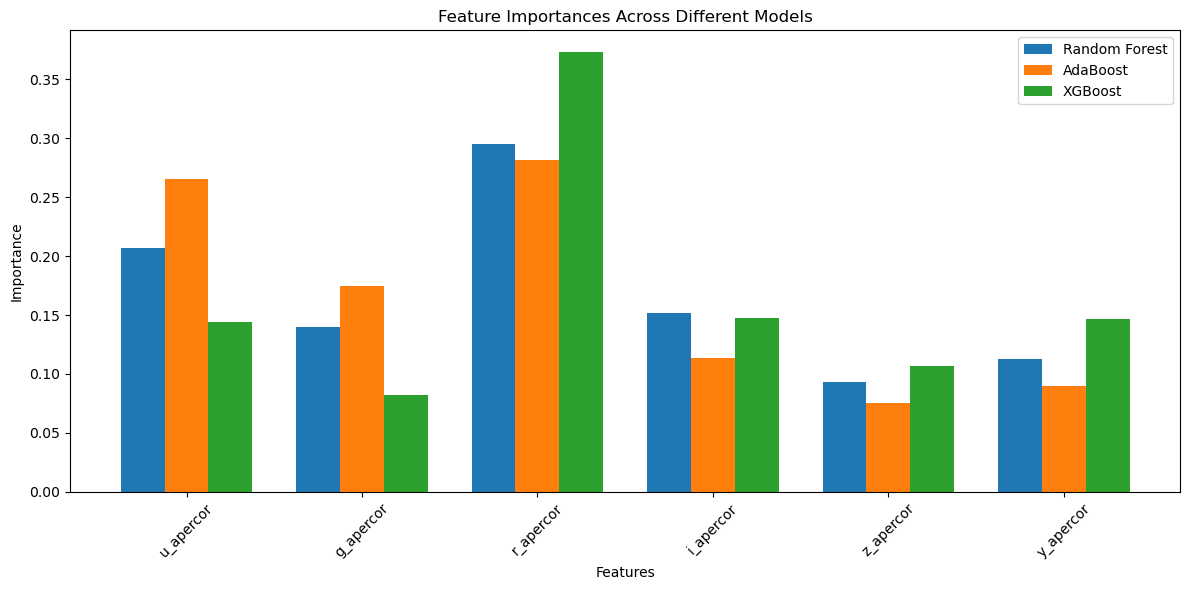

In [79]:
# Extract feature importances
feature_importances = {}
for name, model in models.items():
    feature_importances[name] = model.feature_importances_

# Plot feature importances
feature_names = sel_features.columns
x = np.arange(len(feature_names))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, feature_importances['Random Forest'], width, label='Random Forest')
plt.bar(x, feature_importances['AdaBoost'], width, label='AdaBoost')
plt.bar(x + width, feature_importances['XGBoost'], width, label='XGBoost')

plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances Across Different Models')
plt.xticks(x, feature_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [81]:
# Print the feature rankings for each model
for name, importances in feature_importances.items():
    indices = np.argsort(importances)[::-1]
    print(f"\n{name} Feature Ranking:")
    for i, idx in enumerate(indices):
        print(f"{i+1}. {feature_names[idx]} ({importances[idx]:.4f})")


Random Forest Feature Ranking:
1. r_apercor (0.2952)
2. u_apercor (0.2070)
3. i_apercor (0.1519)
4. g_apercor (0.1400)
5. y_apercor (0.1131)
6. z_apercor (0.0928)

AdaBoost Feature Ranking:
1. r_apercor (0.2816)
2. u_apercor (0.2654)
3. g_apercor (0.1746)
4. i_apercor (0.1136)
5. y_apercor (0.0896)
6. z_apercor (0.0752)

XGBoost Feature Ranking:
1. r_apercor (0.3729)
2. i_apercor (0.1474)
3. y_apercor (0.1463)
4. u_apercor (0.1439)
5. z_apercor (0.1071)
6. g_apercor (0.0825)
[CV] END estimator__max_depth=6, learning_rate=0.3, loss=linear, n_estimators=20; total time=   1.0s
[CV] END estimator__max_depth=6, learning_rate=0.3, loss=linear, n_estimators=50; total time=   1.7s
[CV] END estimator__max_depth=6, learning_rate=0.3, loss=linear, n_estimators=100; total time=   2.8s
[CV] END estimator__max_depth=6, learning_rate=0.3, loss=square, n_estimators=20; total time=   0.7s
[CV] END estimator__max_depth=6, learning_rate=0.3, loss=square, n_estimators=20; total time=   0.7s
[CV] END esti

In [82]:
"""
Feature Importance Analysis in Ensemble Methods for Redshift Estimation
1. Consistency across models

The r-band (r_apercor) dominates as the most important feature across all three models (29-37% importance)
u-band and i-band consistently appear in the top three features
This cross-model consistency provides strong evidence that these spectral bands capture fundamental relationships with redshift

2. Differences between models

Random Forest: More balanced distribution, giving meaningful weight to all six bands
AdaBoost: Concentrates ~55% of importance in just two bands (r and u)
XGBoost: Shows unique preference patterns, elevating y-band importance while downgrading g-band

3. Physics interpretation

The importance of r-band aligns with the 4000Å break feature that shifts through optical bands with redshift
The balanced importance of both blue (u, g) and red (i, z, y) bands reflects how galaxy spectral features move across the electromagnetic spectrum with increasing distance
The models have independently discovered the wavelength ranges most sensitive to redshift changes

4. Model differences explained

Random Forest: By sampling random feature subsets for each tree, naturally distributes importance more evenly
AdaBoost: Sequential error-focused learning leads to heavier weighting of the most discriminative features
XGBoost: Built-in regularization prevents over-reliance on any single feature, producing a more balanced approach

5. Practical implications

A simplified model using only r, u, and i bands could potentially capture ~65-75% of the predictive power
For large-scale galactic surveys, focusing computational resources on these key bands could optimize efficiency
Feature importance provides guidance for instrument design and observational strategies in future surveys
"""

'\nFeature Importance Analysis in Ensemble Methods for Redshift Estimation\n1. Consistency across models\n\nThe r-band (r_apercor) dominates as the most important feature across all three models (29-37% importance)\nu-band and i-band consistently appear in the top three features\nThis cross-model consistency provides strong evidence that these spectral bands capture fundamental relationships with redshift\n\n2. Differences between models\n\nRandom Forest: More balanced distribution, giving meaningful weight to all six bands\nAdaBoost: Concentrates ~55% of importance in just two bands (r and u)\nXGBoost: Shows unique preference patterns, elevating y-band importance while downgrading g-band\n\n3. Physics interpretation\n\nThe importance of r-band aligns with the 4000Å break feature that shifts through optical bands with redshift\nThe balanced importance of both blue (u, g) and red (i, z, y) bands reflects how galaxy spectral features move across the electromagnetic spectrum with increasi